In [1]:
import pandas as pd
#!pip install sklearn


In [2]:
file_names_fake = pd.read_csv('data/Fake.csv')
file_names_fake['real'] = 'Fake'
file_names_true = pd.read_csv('data/True.csv')
file_names_true['real'] = 'True'
file_names = file_names_fake.append(file_names_true, ignore_index=True)
file_names.head()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3220\3723827731.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  file_names = file_names_fake.append(file_names_true, ignore_index=True)


,title,text,subject,date,real
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


In [3]:
file_names.isna().sum()

title      0
text       0
subject    0
date       0
real       0
dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(file_names, test_size=0.2, random_state=25)
data_train = data_train.sample(5000)
data_test = data_test.sample(5000)

In [9]:
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
def clean_review(review_text, tokenizer, stemmer, stopwords):    
    
    #tokens (eliminamos todos los signos de puntuación)
    words = tokenizer.tokenize(review_text)
    
    # stemming: raiz y minúsculas:
    stem_words = [stemmer.stem(x) for x in words]
    
    # eliminamos stopwords (ya pasaron por stem)
    clean_words = [x for x in stem_words if x not in stopwords]
    
    result = " ".join(clean_words)
    
    return(result)

In [11]:
tokenizer = RegexpTokenizer(r"\w+")
englishStemmer = SnowballStemmer("english")
stopwords_en = stopwords.words('english')
stopwords_en.append('reuter')
stopwords_en.append('said')
stopwords_en.append('Reuters')
stopwords_en.append('via')
stopwords_en.append('imag')
stopwords_en.append('https')
stopwords_en.append('com')
stopwords_en.append('one')
stopwords_en.append('u')
stopwords_en.append('also')
stopwords_en.append('would')
stopwords_en.append('featur')
stopwords_en.append('pic')
stopwords_en.append('us')
stopwords_en_stem = [englishStemmer.stem(x) for x in stopwords_en]

In [12]:
import numpy as np
from tqdm import tqdm
tqdm.pandas()

clean_train = data_train.text.progress_apply(lambda x: clean_review(x, tokenizer, englishStemmer, stopwords_en_stem))
clean_test = data_test.text.progress_apply(lambda x: clean_review(x, tokenizer, englishStemmer, stopwords_en_stem))


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 252.89it/s]


In [9]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(clean_train)
X_train_sparse = count_vectorizer.transform(clean_train)
X_test_sparse = count_vectorizer.transform(clean_test)

In [10]:
X_train = pd.DataFrame(X_train_sparse.todense(), 
             columns = count_vectorizer.get_feature_names()) 
y_train = data_train.real

In [11]:
X_test = pd.DataFrame(X_test_sparse.todense(), 
             columns = count_vectorizer.get_feature_names()) 
y_test = data_test.real

In [7]:
from os import path
# from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
text_fake = " ".join(text for text in file_names[file_names['real']=='Fake'].text)
text_true = " ".join(text for text in file_names[file_names['real']=='True'].text)
wordcloud_fake = WordCloud(stopwords=stopwords_en, max_words=100, background_color="white").generate(text_fake)
wordcloud_true = WordCloud(stopwords=stopwords_en, max_words=100, background_color="white").generate(text_true)

ModuleNotFoundError: No module named 'PIL'

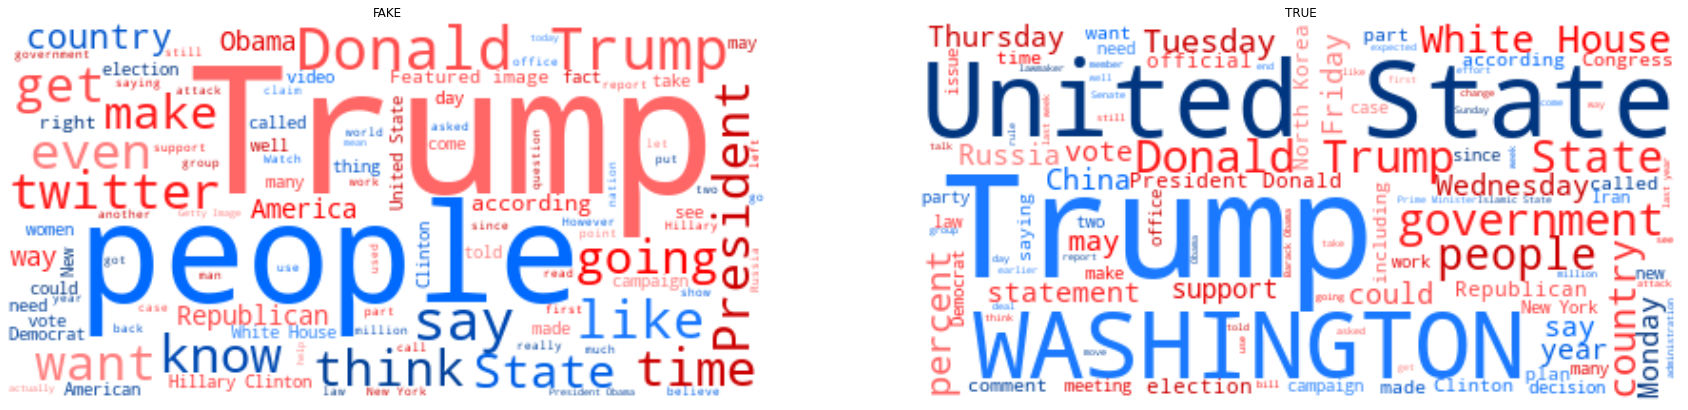

In [13]:
fig, axs = plt.subplots(1, 2,figsize=(30,10))

def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    blues = "hsl(215,100%%, %d%%)" % np.random.choice(np.arange(25, 65, 5, dtype=int))
    reds = "hsl(0,100%%, %d%%)" % np.random.choice(np.arange(40, 80, 5, dtype=int))
    choice = np.random.choice([0, 1])
    if choice == 0:
        return blues
    else:
        return reds

# Display the generated image:
#axs[0].imshow(wordcloud_fake, interpolation='bilinear')
axs[0].imshow(wordcloud_fake.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[0].axis("off")
axs[0].title.set_text('FAKE')
axs[1].imshow(wordcloud_true.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
#axs[1].imshow(wordcloud_true, interpolation='bilinear')
axs[1].axis("off")
axs[1].title.set_text('TRUE')
plt.show()

#### Modelo de Reg. Logistica

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [15]:
reg_model = LogisticRegression(C = 0.05, solver="newton-cg", penalty="l2")
reg_model.fit(X_train, y_train)
print ("Final Accuracy: %s" 
        % accuracy_score(y_test, reg_model.predict(X_test)))

Final Accuracy: 0.9564


In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, reg_model.predict(X_test))
axis_labels = np.sort(y_test.unique())
sns.heatmap(cm, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

NameError: name 'confusion_matrix' is not defined

In [17]:
Coef_reg_model = pd.DataFrame(np.transpose(reg_model.coef_), index=X_train.columns, columns=['Coef'])
Coef_reg_model['coef_abs'] = abs(Coef_reg_model['Coef'])
Coef_reg_model = Coef_reg_model.reset_index(-1)
Coef_reg_model['words'] = Coef_reg_model['index'] 
Coef_reg_model['freq'] = (round(Coef_reg_model['coef_abs'] / Coef_reg_model.coef_abs.sum() * Coef_reg_model.shape[0] * 1000 , 0)).apply(lambda x: int(x))
Coef_reg_model['odds_direction'] = Coef_reg_model['Coef'].apply(lambda x: 'Negative' if x<0 else 'Positive')
Coef_reg_model_positive = Coef_reg_model[Coef_reg_model['odds_direction']=='Positive']
Coef_reg_model_positive = Coef_reg_model_positive.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)
Coef_reg_model_negative = Coef_reg_model[Coef_reg_model['odds_direction']=='Negative']
Coef_reg_model_negative = Coef_reg_model_negative.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)

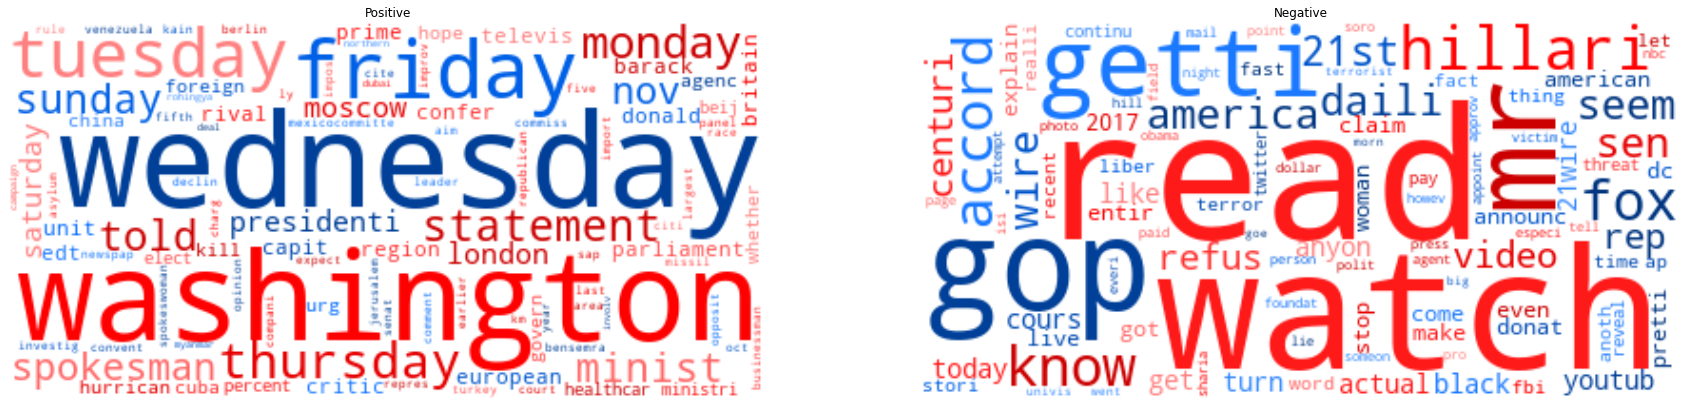

In [18]:
tuples_pos = Coef_reg_model_positive.set_index('words').T.to_dict('index')
tuples_neg = Coef_reg_model_negative.set_index('words').T.to_dict('index')
wordcloud_positive = WordCloud(max_words=100, background_color="white").generate_from_frequencies(dict(tuples_pos['freq']))
wordcloud_negative = WordCloud(max_words=100, background_color="white").generate_from_frequencies(dict(tuples_neg['freq']))

fig, axs = plt.subplots(1, 2,figsize=(30,10))
# Display the generated image:
axs[0].imshow(wordcloud_positive.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[0].axis("off")
axs[0].title.set_text('Positive')
axs[1].imshow(wordcloud_negative.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
axs[1].axis("off")
axs[1].title.set_text('Negative')
plt.show()

## Naive Bayes

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
NB_model.score(X_test, y_test)

0.9256

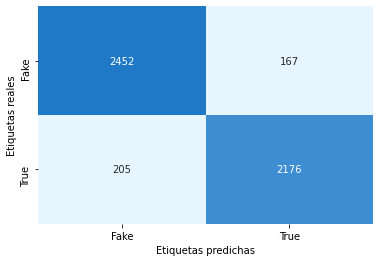

In [20]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, NB_model.predict(X_test))
axis_labels = np.sort(y_test.unique())
sns.heatmap(cm, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

## Modelo de Reg. Logistica Truncando palabras

In [21]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 200);

X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

In [22]:
reg_model_svd = LogisticRegression(C = 0.01, solver="newton-cg", penalty="l2")
reg_model_svd.fit(X_train_svd, y_train)
reg_model_svd.score(X_test_svd, y_test)

0.939

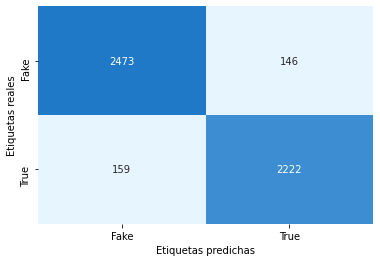

In [23]:
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, reg_model_svd.predict(X_test_svd))
axis_labels = np.sort(y_test.unique())
sns.heatmap(cm, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

## Modelo de Reg. Logistica con conjunto de palabras

In [24]:
count_vectorizer_bigram = CountVectorizer(ngram_range = (1, 2))
count_vectorizer_bigram.fit(clean_train)
X_train_bigram_sparse = count_vectorizer_bigram.transform(clean_train)
X_test_bigram_sparse = count_vectorizer_bigram.transform(clean_test)

In [25]:
reg_model_bigram = LogisticRegression(C = 0.25, solver="newton-cg", penalty="l2")
reg_model_bigram.fit(X_train_bigram_sparse, y_train)
reg_model_bigram.score(X_test_bigram_sparse, y_test)

0.9572

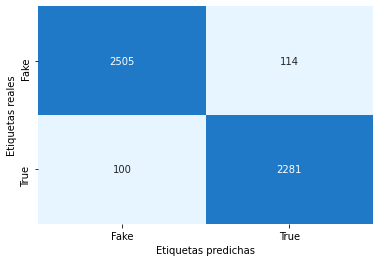

In [26]:
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, reg_model_bigram.predict(X_test_bigram_sparse))
axis_labels = np.sort(y_test.unique())
sns.heatmap(cm, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

## Decision Tree Classifier

In [27]:
import seaborn as sns
from sklearn import tree

In [28]:
'''data_train, data_test = train_test_split(file_names, test_size=0.5, random_state=25)
clean_test = data_test.text.progress_apply(lambda x: clean_review(x, tokenizer, englishStemmer, stopwords_en_stem))
X_test_sparse = count_vectorizer.transform(clean_test)
X_test = pd.DataFrame(X_test_sparse.todense(), 
             columns = count_vectorizer.get_feature_names()) 
y_test = data_test.real'''

'data_train, data_test = train_test_split(file_names, test_size=0.5, random_state=25)\nclean_test = data_test.text.progress_apply(lambda x: clean_review(x, tokenizer, englishStemmer, stopwords_en_stem))\nX_test_sparse = count_vectorizer.transform(clean_test)\nX_test = pd.DataFrame(X_test_sparse.todense(), \n             columns = count_vectorizer.get_feature_names()) \ny_test = data_test.real'

In [29]:
my_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
my_tree.fit(X_train, y_train)
my_tree.score(X_test, y_test)

0.7674

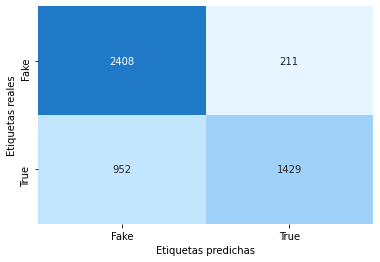

In [30]:
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, my_tree.predict(X_test))
axis_labels = np.sort(y_test.unique())
sns.heatmap(cm, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

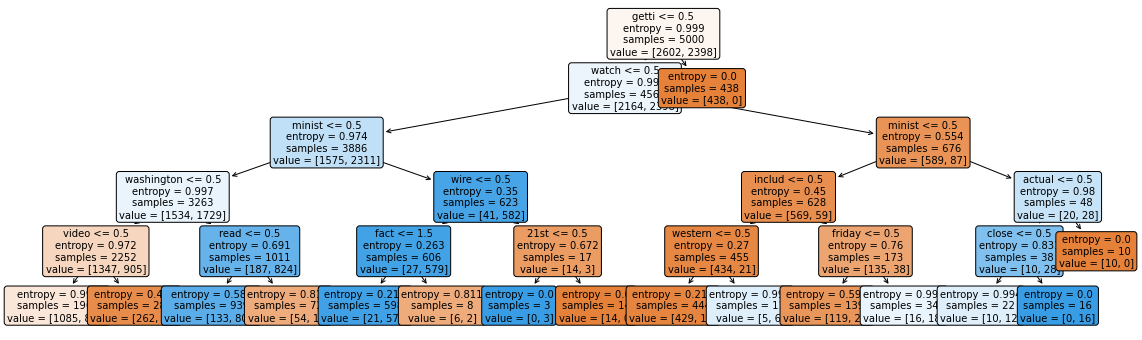

In [31]:
plt.figure(figsize=(20,6))
tree.plot_tree(my_tree,feature_names = X_train.columns,filled=True,rounded=True, fontsize = 10)
plt.show()

## Random Decision Tree Classifier and Extra random

In [59]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=1000, 
                                      criterion='gini', 
                                      max_depth = 4, 
                                      bootstrap=True, 
                                      n_jobs = -1, 
                                      random_state = 127,
                                      max_samples= 0.3)
random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.912

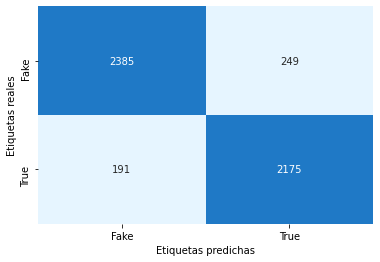

In [60]:
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, random_forest.predict(X_test))
axis_labels = np.sort(y_test.unique())
sns.heatmap(cm, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [62]:
from sklearn.ensemble import ExtraTreesClassifier
extra_random_forest = ExtraTreesClassifier(n_estimators=1000, 
                                      criterion='gini', 
                                      max_depth = 4, 
                                      bootstrap=True, 
                                      n_jobs = -1, 
                                      random_state = 127,
                                      max_samples= 0.3)
extra_random_forest.fit(X_train, y_train)
extra_random_forest.score(X_test, y_test)

0.9078

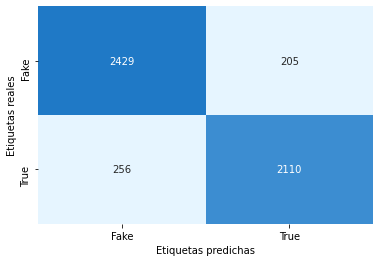

In [63]:
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, extra_random_forest.predict(X_test))
axis_labels = np.sort(y_test.unique())
sns.heatmap(cm, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

## Boosting de Modelos

In [64]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

base_classifier = ExtraTreesClassifier(n_estimators=100, 
                                      criterion='gini', 
                                      max_depth = 4, 
                                      bootstrap=True, 
                                      n_jobs = -1, 
                                      random_state = 127,
                                      max_samples= 0.3)

boost_tree = AdaBoostClassifier(base_estimator = base_classifier, 
                            n_estimators = 200,
                            learning_rate = 0.8,                                       
                            random_state = 127)
boost_tree.fit(X_train, y_train) 
boost_tree.score(X_test, y_test)

0.9706

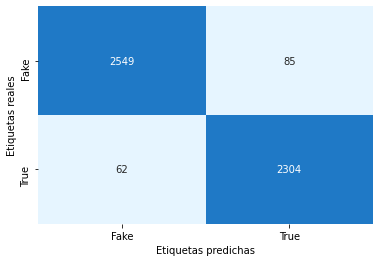

In [65]:
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, boost_tree.predict(X_test))
axis_labels = np.sort(y_test.unique())
sns.heatmap(cm, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [68]:
gb_classifier = GradientBoostingClassifier(loss = 'deviance',
                                           learning_rate=0.6,
                                           n_estimators = 200,
                                           subsample=1,
                                           criterion='mse',
                                           random_state = 127)

gb_classifier.fit(X_train, y_train)
gb_classifier.score(X_test, y_test)

0.961

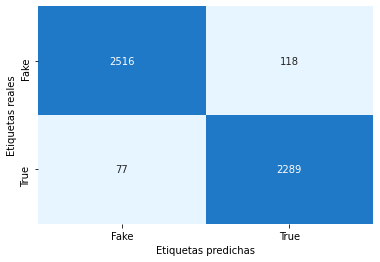

In [ ]:
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, gb_classifier.predict(X_test))
axis_labels = np.sort(y_test.unique())
sns.heatmap(cm, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [34]:
#!pip install xgboost
from xgboost import XGBClassifier
y_train_xg = y_train.apply(lambda x: 1 if x=='Fake' else 0)
y_test_xg = y_test.apply(lambda x: 1 if x=='Fake' else 0)
model_xg = XGBClassifier(n_jobs=-1, use_label_encoder=False, n_estimators= 100, max_depth=4, learning_rate= 0.05)
model_xg.fit(X_train,y_train_xg)
model_xg.score(X_test, y_test_xg)

0.9262

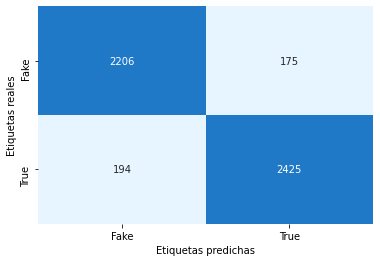

In [36]:
myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test_xg, model_xg.predict(X_test))
axis_labels = np.sort(y_test.unique())
sns.heatmap(cm, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

## A traves de webscraping se buscan noticias para obtener más datos de testing

In [37]:
#!pip install selenium
#!pip install webdriver-manager
#!pip install bs4
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time    
import pandas as pd

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(service=Service(ChromeDriverManager().install()),options=chrome_options)

def get_text_from_url_bbc(url):
    wd.get(url)

    time.sleep(1)

    soup = BeautifulSoup(wd.page_source)
    text = soup.find_all('div', {'data-component': 'text-block'}) #(?P<text>\>(.*?)\<)
    text2 = ""
    for i in text:
        try:
            text2 = i.text+text2
        except:
            text2 = ""+text2
    return text2    



====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/101.0.4951.41/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\Lucas Choconi\.wdm\drivers\chromedriver\win32\101.0.4951.41]


In [38]:
import requests
import warnings
warnings.filterwarnings("ignore")
#https://newsapi.org/docs
response = requests.get("https://newsapi.org/v2/top-headlines?sources=bbc-news&apiKey=1f83e742c8804de0a5d427510829f79b")

list_urls = []
for i in range(0,len(response.json()['articles'])):
    list_urls.append(response.json()['articles'][i]['url'])  
    
list_texts = []
for i in range(0,len(list_urls)):
    list_texts.append(get_text_from_url_bbc(list_urls[i]))

In [39]:
data_texts_text = pd.DataFrame(list_texts, columns=['text'])
data_texts_text['len'] = data_texts_text.text.apply(lambda x: len(x))
data_texts_text['real'] = 'True'
data_texts_text = data_texts_text[data_texts_text.len>0]
clean_texts_test = data_texts_text.text.progress_apply(lambda x: clean_review(x, tokenizer, englishStemmer, stopwords_en_stem))

X_test_sparse_texts = count_vectorizer.transform(clean_texts_test)
X_test_texts = pd.DataFrame(X_test_sparse_texts.todense(), 
             columns = count_vectorizer.get_feature_names()) 
X_test_svd_texts = svd.transform(X_test_texts)
X_test_bigram_sparse_texts = count_vectorizer_bigram.transform(clean_texts_test)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 42.42it/s]


In [41]:
data_texts_text['predict_reg_base'] = reg_model.predict(X_test_texts)
data_texts_text['predict_prob_reg_base'] = reg_model.predict_proba(X_test_texts).T[0]

data_texts_text['predict_svd'] = reg_model_svd.predict(X_test_svd_texts)
data_texts_text['predict_prob_svd'] = reg_model_svd.predict_proba(X_test_svd_texts).T[0]

data_texts_text['predict_bigram'] = reg_model_bigram.predict(X_test_bigram_sparse_texts)
data_texts_text['predict_prob_bigram'] = reg_model_bigram.predict_proba(X_test_bigram_sparse_texts).T[0]

data_texts_text['predict_my_tree'] = my_tree.predict(X_test_texts)
data_texts_text['predict_prob_my_tree'] = my_tree.predict_proba(X_test_texts).T[0]

data_texts_text

,text,len,real,predict_reg_base,predict_prob_reg_base,predict_svd,predict_prob_svd,predict_bigram,predict_prob_bigram,predict_my_tree,predict_prob_my_tree
1,"Andriy Yermak, chief of staff to Ukraine's pre...",3066,True,True,0.016079,True,0.029188,True,0.000316,True,0.035117
2,That is why they are keen to be as transparent...,4286,True,True,0.212680,True,0.233073,True,0.027819,Fake,0.551601
3,"""At the beginning of the war, they assumed tha...",5827,True,Fake,0.964088,Fake,0.927323,Fake,0.979362,True,0.035117
4,Please note that the SecureDrop link will only...,12461,True,Fake,0.999985,Fake,0.998355,Fake,0.999995,True,0.454545
5,"Follow BBC News South West on Twitter, Faceboo...",2456,True,Fake,0.973662,Fake,0.852072,Fake,0.992517,True,0.141640
6,The 13 women awarded damages had taken the uni...,1652,True,Fake,0.698014,Fake,0.718389,Fake,0.778148,Fake,0.551601
7,"According to health officials, the man has bee...",2262,True,True,0.029651,True,0.329673,True,0.007431,Fake,0.551601


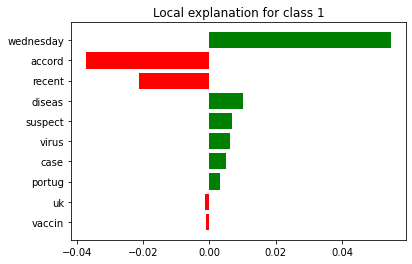

In [44]:
from lime.lime_tabular import LimeTabularExplainer
X_train_explainer = np.array(X_train)
explainer = LimeTabularExplainer(X_train_explainer, 
                                 mode = "classification",
                                 training_labels = y_train,
                                 feature_names = X_train.columns,
                                 discretize_continuous=False)

#i = 13
#data_row = np.array(X_test.iloc[i])
data_row = np.array(X_test_texts.iloc[6])
explanation = explainer.explain_instance(data_row, reg_model.predict_proba, num_features=10)
explanation.as_pyplot_figure();